# 特徴量設計 (feature engineering)

In [145]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [146]:
import datetime
import os
import pathlib

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib as ta
from matplotlib import dates as mdates
from scipy.interpolate import make_smoothing_spline

from funcs.ios import get_excel_sheet
from funcs.tse import get_ticker_name_list

In [147]:
# ソースファイル
date_str = "20250819"
path_excel = f"../excel/tick_{date_str}.xlsx"
code = "7011"
name = get_ticker_name_list([code])[code]
print(code, name)
excel_file = str(pathlib.Path(path_excel).resolve())
df_tick = get_excel_sheet(excel_file, code)
df_tick.index = [
    pd.to_datetime(str(datetime.datetime.fromtimestamp(t))) for t in df_tick["Time"]
]
cols = list(df_tick.columns[~df_tick.columns.isin(["Time"]) ])
df_tick = df_tick[cols]
print(df_tick.head())
df_tick_2 = df_tick.copy()

7011 三菱重工業
                            Price   Volume
2025-08-19 09:01:15.496406   4025  1213700
2025-08-19 09:01:17.326403   4030  1827900
2025-08-19 09:01:17.515900   4030  1827900
2025-08-19 09:01:18.532149   4030  1827900
2025-08-19 09:01:19.536610   4033  1888700


## 加工した特徴量

In [148]:
# 出来高 log(1 + ΔVolume)
df_tick["log1pdVol"] = np.log1p(df_tick["Volume"].diff())

period = 60
# 移動平均
df_tick["MA"] = df_tick["Price"].rolling(period).mean()
# 移動標準偏差
df_tick["MSTD"] = df_tick["Price"].rolling(period).std()
# RSI
df_tick["RSI"] = ta.RSI(df_tick["Price"], timeperiod=period - 1)
# Z-score
df_tick["Zscore"] = [(df_tick["Price"].iloc[r] - df_tick["MA"].iloc[r]) / df_tick["MSTD"].iloc[r] if df_tick["MSTD"].iloc[r] > 0 else 0.0 for r in range(len(df_tick))]

df_tick

,Price,Volume,log1pdVol,MA,MSTD,RSI,Zscore
2025-08-19 09:01:15.496406,4025,1213700,NaN,NaN,NaN,NaN,0.000000
2025-08-19 09:01:17.326403,4030,1827900,13.328078,NaN,NaN,NaN,0.000000
2025-08-19 09:01:17.515900,4030,1827900,0.000000,NaN,NaN,NaN,0.000000
2025-08-19 09:01:18.532149,4030,1827900,0.000000,NaN,NaN,NaN,0.000000
2025-08-19 09:01:19.536610,4033,1888700,11.015362,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...
2025-08-19 15:24:45.057720,3914,25362000,7.863651,3911.233333,1.730746,64.206921,1.598540
2025-08-19 15:24:46.067848,3914,25362000,0.000000,3911.350000,1.675598,64.206921,1.581525
2025-08-19 15:24:47.069456,3915,25368700,8.810012,3911.483333,1.641534,66.566857,2.142306
2025-08-19 15:24:48.080554,3915,25368700,0.000000,3911.600000,1.638519,66.566857,2.075044


## Matplotlib の設定

In [149]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 10

## オリジナルの特徴量

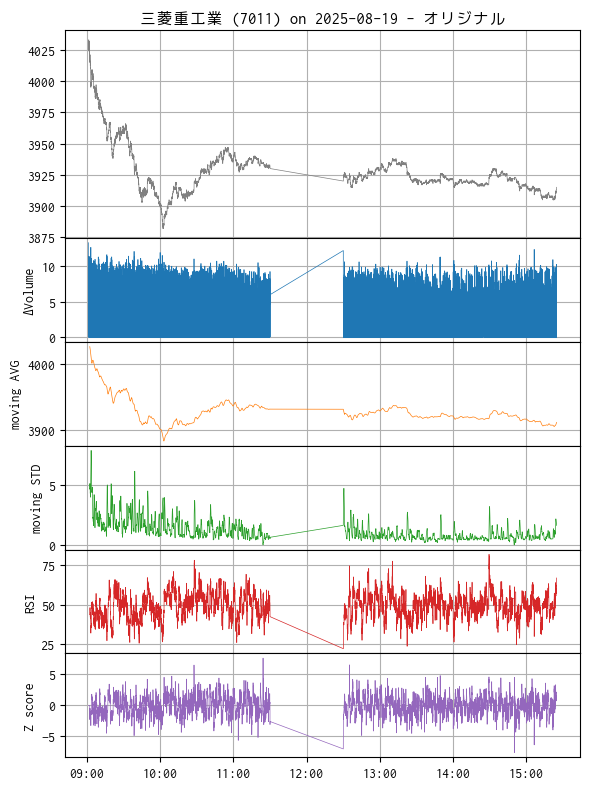

In [150]:
ax = dict()
n = 6
if n > 1:
    fig = plt.figure(figsize=(6, 2 + n))
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        height_ratios=[2 if i == 0 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid()
else:
    fig, ax[0] = plt.subplots(figsize=(6, 3))
    ax[0].grid()

ax[0].plot(df_tick["Price"], color="gray", linewidth=0.5)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_title(f"{name} ({code}) on {df_tick.index[0].strftime('%Y-%m-%d')} - オリジナル")

ax[1].plot(df_tick["log1pdVol"], color="C0", linewidth=0.5)
ax[1].set_ylabel("ΔVolume")

ax[2].plot(df_tick["MA"], color="C1", linewidth=0.5)
ax[2].set_ylabel("moving AVG")

ax[3].plot(df_tick["MSTD"], color="C2", linewidth=0.5)
ax[3].set_ylabel("moving STD")

ax[4].plot(df_tick["RSI"], color="C3", linewidth=0.5)
ax[4].set_ylabel("RSI")

ax[5].plot(df_tick["Zscore"], color="C4", linewidth=0.5)
ax[5].set_ylabel("Z score")

plt.tight_layout()
plt.savefig(f"screenshots/tick_features_{code}_{date_str}_1.png")
plt.show()

## 特徴量設計

In [151]:
# 使用するデータフレーム
df_tick_2

,Price,Volume
2025-08-19 09:01:15.496406,4025,1213700
2025-08-19 09:01:17.326403,4030,1827900
2025-08-19 09:01:17.515900,4030,1827900
2025-08-19 09:01:18.532149,4030,1827900
2025-08-19 09:01:19.536610,4033,1888700
...,...,...
2025-08-19 15:24:45.057720,3914,25362000
2025-08-19 15:24:46.067848,3914,25362000
2025-08-19 15:24:47.069456,3915,25368700
2025-08-19 15:24:48.080554,3915,25368700


In [152]:
# 株価差分
df_tick_2["dPrice"] = df_tick["Price"].diff()
# 出来高 log(1 + ΔVolume)
unit = 100 # 最小取引単位
df_tick_2["dVol"] = np.log1p((df_tick["Volume"] / unit).diff()) * np.sign(df_tick_2["dPrice"])

df_tick_2

,Price,Volume,dPrice,dVol
2025-08-19 09:01:15.496406,4025,1213700,NaN,NaN
2025-08-19 09:01:17.326403,4030,1827900,5.0,8.723069
2025-08-19 09:01:17.515900,4030,1827900,0.0,0.000000
2025-08-19 09:01:18.532149,4030,1827900,0.0,0.000000
2025-08-19 09:01:19.536610,4033,1888700,3.0,6.411818
...,...,...,...,...
2025-08-19 15:24:45.057720,3914,25362000,0.0,0.000000
2025-08-19 15:24:46.067848,3914,25362000,0.0,0.000000
2025-08-19 15:24:47.069456,3915,25368700,1.0,4.219508
2025-08-19 15:24:48.080554,3915,25368700,0.0,0.000000


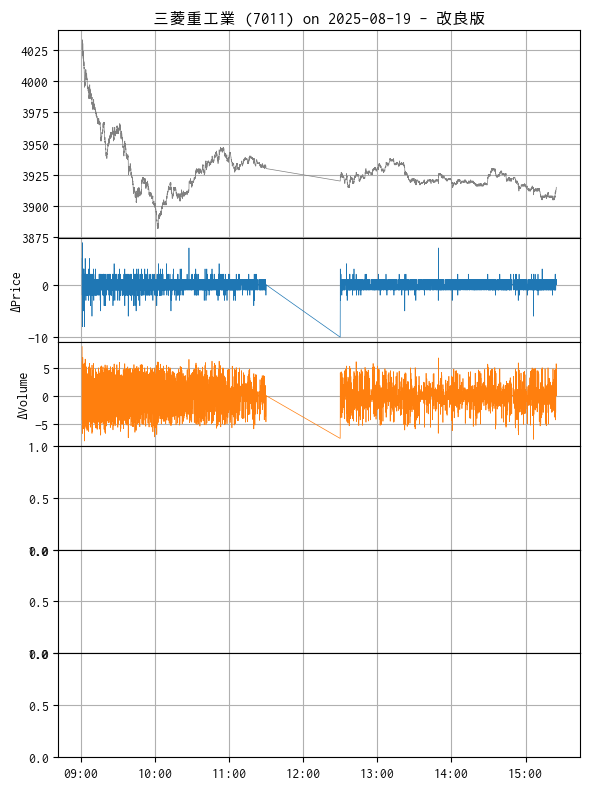

In [153]:
ax = dict()
n = 6
if n > 1:
    fig = plt.figure(figsize=(6, 2 + n))
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        height_ratios=[2 if i == 0 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid()
else:
    fig, ax[0] = plt.subplots(figsize=(6, 3))
    ax[0].grid()

ax[0].plot(df_tick_2["Price"], color="gray", linewidth=0.5)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_title(f"{name} ({code}) on {df_tick.index[0].strftime('%Y-%m-%d')} - 改良版")

ax[1].plot(df_tick_2["dPrice"], color="C0", linewidth=0.5)
ax[1].set_ylabel("ΔPrice")

ax[2].plot(df_tick_2["dVol"], color="C1", linewidth=0.5)
ax[2].set_ylabel("ΔVolume")

plt.tight_layout()
plt.savefig(f"screenshots/tick_features_{code}_{date_str}_2.png")
plt.show()